
## Delta GPTs - (Train on 100, 200, 300 and predict the next 20)

* Model predicts on its own train set
* 105 samples for train and pred - the same 
* gave it first 4 or so 



## Libraries


In [1]:

##!pip install xgboost
## !pip install matplotlib
## !pip install scikit-learn
## !pip install einops


In [2]:

import pandas as pd
import numpy as np


In [3]:

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [4]:


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import torch
import pandas as pd
import sklearn
import random
import math


In [5]:

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## coefficient of determination 
from sklearn.metrics import r2_score


In [6]:

from einops import rearrange
from math import sqrt, log



## Positional Encoding example


In [7]:

def PositionalEncoding(q_len, d_model, normalize=True):
    pe = torch.zeros(q_len, d_model)
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe



## Read the data


In [8]:

for_RNN_data_CIVS = pd.read_csv('input/RNN_time_DELAYS_2000_PerCast_rcalix.csv')


In [9]:

for_RNN_data_CIVS


,Unnamed: 0,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,...,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,HOT_METAL_TEMP_f3,cokerate_f4
0,1,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,...,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,2730.002686,884.0
1,2,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,...,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,2730.002686,884.0
2,3,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,...,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,2729.690821,884.0
3,4,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,...,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,2703.051419,884.0
4,5,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,...,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,2741.996582,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,1379,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,...,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,2730.002686,884.0
1379,1380,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,...,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,2730.002686,884.0
1380,1381,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,...,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,2730.002686,884.0
1381,1382,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,...,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,2730.002686,884.0


In [10]:

cols_list_DF = for_RNN_data_CIVS.columns.values.tolist()
cols_list_DF


['Unnamed: 0',
 'SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'HOT_METAL_TEMP_f3',
 'cokerate_f4']

In [11]:

l_new = ['SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'HOT_METAL_TEMP_f3',
 'cokerate_f4']


In [12]:


l_map_dates = ['SI_f1',
 'Date_Map',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'CNUM',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'HOT_METAL_TEMP_f3',
 'cokerate_f4']




In [13]:

for_RNN_data_CIVS = for_RNN_data_CIVS[l_new]


In [14]:

for_RNN_data_CIVS 


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,...,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,HOT_METAL_TEMP_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,...,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,2730.002686,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,...,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,2730.002686,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,...,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,2729.690821,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,...,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,2703.051419,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,...,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,2741.996582,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,...,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,2730.002686,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,...,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,2730.002686,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,...,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,2730.002686,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,...,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,2730.002686,884.0



## The Dates Map


In [15]:

df_Dates_Map = pd.read_csv('input/RC_CNUM_RNN_time_DELAYS_2000_PerCast_rcalix.csv')

df_Dates_Map = df_Dates_Map[ l_map_dates ]

df_Dates_Map


,SI_f1,Date_Map,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,...,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,HOT_METAL_TEMP_f3,cokerate_f4
0,0.719500,2022-01-01 00:45:00,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,...,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,2730.002686,884.0
1,0.710486,2022-01-01 08:43:00,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,...,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,2730.002686,884.0
2,0.666106,2022-01-01 10:17:00,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,...,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,2729.690821,884.0
3,0.675145,2022-01-01 12:40:00,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,...,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,2703.051419,884.0
4,0.776831,2022-01-01 15:06:00,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,...,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,2741.996582,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,2021-12-31 13:10:00,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,...,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,2730.002686,884.0
1379,0.646000,2021-12-31 14:41:00,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,...,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,2730.002686,884.0
1380,0.654667,2021-12-31 16:15:00,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,...,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,2730.002686,884.0
1381,0.591667,2021-12-31 17:40:00,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,...,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,2730.002686,884.0



## Plots


In [16]:

plt.rcParams["figure.figsize"] = [15, 5]


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

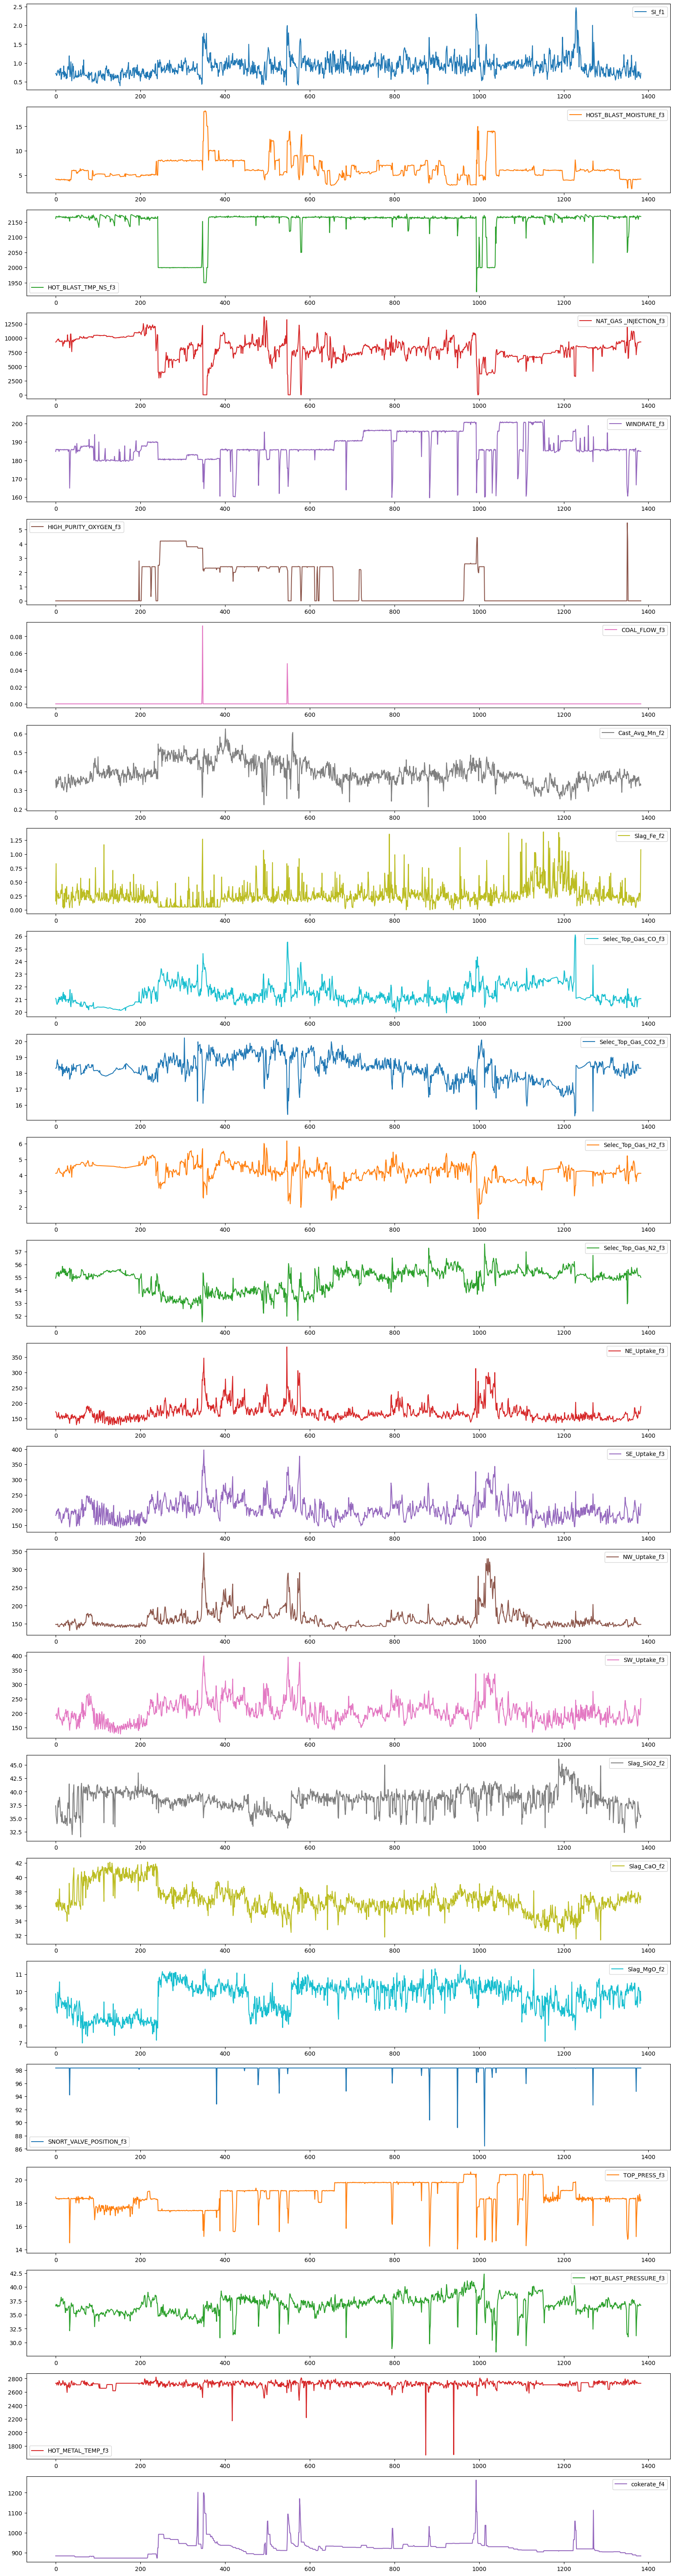

In [17]:

for_RNN_data_CIVS.plot( kind='line', subplots=True, figsize=(20,80),
        sharex=False, sharey=False, legend=True )


In [18]:

print(for_RNN_data_CIVS.shape)


(1383, 25)



## Parameters


In [19]:

pd.options.display.max_columns = None



## Standardize (Scaling)


In [20]:

def standardize_x_scales( data_gpt_pd ):


    data_gpt = torch.tensor(data_gpt_pd.values).float()
        
    epsilon = 0.0001

    print( data_gpt.shape)        
    
    x_means      = data_gpt .mean(0,  keepdim=True)
    x_deviations = data_gpt .std( 0,  keepdim=True) + epsilon

    ## x_train_tr_scaled = (x_train_tr - x_means) / x_deviations
    ## y_test_tr_scaled  = (y_test_tr  - y_means) / y_deviations
    
    return data_gpt, x_means, x_deviations


In [21]:

## x_means      = simple_x_train.mean(0, keepdim=True ) 
## x_deviations = simple_x_train.std( 0, keepdim=True) + epsilon



## Shift and create batches


In [23]:

def get_batch( data_gpt ):
    
    ix = torch.randint(   len(data_gpt) - block_size, (batch_size,)   )

    x  = torch.stack(    [  data_gpt[   i   : i+block_size    ]   for i in ix ]    ) 
    y  = torch.stack(    [  data_gpt[   i+1 : i+1+block_size  ]   for i in ix ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y



## NN Architectures


In [24]:

class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        
        self.key   = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.query = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.value = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]

        tril_def = torch.tril( torch.ones(block_size, block_size) )  ## [40, 40]
        
        self.register_buffer(
                  'tril', 
                  tril_def
               )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        B, T, E = x.shape   ## [batch_size, 40, 512] or [B, 15, 512]
        
        k = self.key(   x )            ## k = (B, T, 64)
        q = self.query( x )            ## q = (B, T, 64)

        E2 = 64     ## I think this is 64 and not 512
        ## (B, T, E) @ (B, E, T)  -> (B, T, T)
        wei = q @ k.transpose(-2, -1) * E2 ** -0.5        
        
        wei = wei.masked_fill(
                      self.tril[:T, :T] == 0, 
                      float('-inf')
        )   
        
        ## (B, T, T)
        wei = F.softmax( wei, dim= -1 )         ## (B, T, T)
        wei = self.dropout(   wei   )
        
        v   = self.value(  x  )   ## x = (B, 40, E)
        out = wei @ v             ## (B, T, T) @ (B, T, 64) -> (B, T, 64)
        
        return out
        


In [25]:

class FeedForward(nn.Module):

    def __init__(self, n_embd):         ## 512
        
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),      ## [512, 4*512]
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),      ## [4*512, 512]
            nn.Dropout(dropout),
        )
        
    def forward(self, x):
        return self.net(x)


In [26]:

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):    ## (8, 64)
        super().__init__()
        self.heads = nn.ModuleList(  [ Head(head_size) for _ in range(num_heads) ] )
        self.proj  = nn.Linear(n_embd, n_embd)   ## 512, 512
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat(   [ h(x) for h in self.heads ], dim = -1   )
        out = self.proj(  out   )
        out = self.dropout(   out   )
        return out


In [27]:

class Block(nn.Module):
    
    def __init__(self, n_embd, n_head):     ## (512, 8)
        super().__init__()
        head_size = n_embd // n_head        ## 64
        self.sa   = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward( n_embd)    ## 512
        self.ln1  = nn.LayerNorm(n_embd)
        self.ln2  = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(     self.ln1(x)      )
        x = x + self.ffwd(   self.ln2(x)      )
        return x


In [28]:

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x_avg = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)

        x = x + x_avg
        
        return x


In [29]:

class Time_Series_GPT(nn.Module):
    
    def __init__(self, seq_length, input_size, output_size):
        
        super().__init__()
        
        self.output_size = output_size
        self.seq_length  = seq_length       ## 40 or 15
        self.input_size  = input_size

        vocab_size = 30
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)   ## [65, 512]
        
        self.pos_emb_table         = nn.Embedding(block_size, n_embd)     ## [block, 512] or [40, 512]
        
        self.blocks = nn.Sequential(
                *[   Block(n_embd, n_head=n_head) for _ in range(n_layer)    ]
        )
        
        self.ln_f        = nn.LayerNorm(  n_embd    )        
        self.lm_ffw_head = nn.Linear(n_embd, 27)  ## [512, 65] # FFW Layer

        #######################################################################

        self.map_24_512 = nn.Linear(27, 512)  ## [24, 512] # projection
        self.map_act    = nn.ReLU()

        #######################################################################


        self.map_24_512_1 = nn.Linear(27, 100)  ## [24, 512] # projection
        self.map_act1     = nn.ReLU()
        self.LayerNorm1   = nn.LayerNorm( 100 )
        self.map_24_512_2 = nn.Linear(100, 200)  ## [24, 512] # projection
        self.map_act2     = nn.ReLU()
        self.LayerNorm2   = nn.LayerNorm( 200 )
        self.map_24_512_3 = nn.Linear(200, 512)  ## [24, 512] # projection
        self.dropout_24_512 = nn.Dropout(0.2)
   
        #####################################

        self.linear1_TS_int = nn.Linear(27, 15)
        self.act1_TS_int    = nn.ReLU()
        self.linear2_TS_int = nn.Linear(15, 9)
        self.act2_TS_int    = nn.ReLU()
        self.linear3_TS_int = nn.Linear(9, vocab_size)
        self.act3_TS_int    = nn.Softmax(dim=1)
        self.dropout_TS_int = nn.Dropout(0.25)
        
        #####################################

        self.conv_idx     = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
        self.bn1 = nn.BatchNorm2d(1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv_idx2     = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 
        self.bn2 = nn.BatchNorm2d(1)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv_idx3     = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, bias=False) 

        
        self.per_conv_idx = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, padding=2, bias=False) 
        self.per_bn1 = nn.BatchNorm2d(3)
        self.per_relu1 = nn.ReLU(inplace=True)
        self.per_conv_idx2     = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2, bias=False) 
        self.per_bn2 = nn.BatchNorm2d(6)
        self.per_relu2 = nn.ReLU(inplace=True)
        self.per_conv_idx3     = nn.Conv2d(in_channels=6, out_channels=1, kernel_size=5, padding=2, bias=False) 
  
        #####################################
        

    def forward(self,  idx, targets):

  

        #####################

        B = idx.shape[0]       ## 8 batch 
        T = idx.shape[1]       ## 40 or 15

        ############################################################


        idx = self.map_24_512_1( idx )       ## (8, 15, 24) goes in
        idx = self.map_act1(     idx )
        idx = self.dropout_24_512(     idx )
        idx = self.LayerNorm1(   idx )
        idx = self.map_24_512_2( idx )
        idx = self.map_act2(     idx )
        idx = self.dropout_24_512(     idx )
        idx = self.LayerNorm2(   idx )
        idx = self.map_24_512_3( idx )
        
        tok_emb = idx       ## (B, 15, 512)

        ###########################################################
        ## convolutions

        idx_4d_conv = idx.unsqueeze(1)
        residual = idx_4d_conv
        conv_emb = self.conv_idx( idx_4d_conv )
        conv_emb = self.bn1(conv_emb)
        conv_emb = self.relu1(conv_emb)
        conv_emb = self.conv_idx2( conv_emb )
        conv_emb = self.bn2(conv_emb)
        conv_emb = self.relu2(conv_emb)
        conv_emb = self.conv_idx3( conv_emb)
        conv_emb = residual + conv_emb
        conv_emb = conv_emb.squeeze(1)
        

        ## Permute
        idx_4d_conv_permute = rearrange(idx_4d_conv, 'b c l m -> b c m l')
        per_residual = idx_4d_conv_permute
        per_conv_emb = self.per_conv_idx( idx_4d_conv_permute )
        per_conv_emb = self.per_bn1(per_conv_emb)
        per_conv_emb = self.per_relu1(per_conv_emb)
        per_conv_emb = self.per_conv_idx2( per_conv_emb )
        per_conv_emb = self.per_bn2( per_conv_emb )
        per_conv_emb = self.per_relu2( per_conv_emb )
        per_conv_emb = self.per_conv_idx3( per_conv_emb )
        per_conv_emb = per_residual + per_conv_emb
        per_conv_emb = rearrange(per_conv_emb, 'b c m l -> b c l m')
        per_conv_emb = per_conv_emb.squeeze(1)

        ###########################################################
        
        pos_emb = self.pos_emb_table( torch.arange(T, device=device) )  
        
        ## pos_emb = PositionalEncoding(T, n_embd, normalize=True)   ## sines and cosines

        ###########################################################
        
        ## x = tok_emb + pos_emb + conv_emb + per_conv_emb    ## [B, T, E] or [N, 40, 512], now [N, 15, 24]

        x = tok_emb + pos_emb 

        ############################################################
        
        x = self.blocks(  x  )   ## (B, T, E)   
        x = self.ln_f(    x  )   ## (B, T, E)   ## norm
        logits = self.lm_ffw_head(x)         ## [B, 40, 65]  or [N, 15, 24]
        
        return logits
        
        
    def generate(self, idx, max_new_tokens):    ## idx is (B, T)
        print("max tokens ", max_new_tokens)
        print(idx.shape)
        for _ in range(max_new_tokens):
            ## crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:, :]
            logits = self(idx_cond, 0 )    ## ## get preds
            logits = logits[:, -1, :]    ## focus on last one (B, E)
            logits = logits.unsqueeze(0)
            ## probs = F.softmax(logits, dim= -1)    ## (B, E) get probs
            ## idx_next = torch.multinomial(probs, num_samples=1)     ## (B, 1) selected
            idx = torch.cat(  (idx, logits), dim=1  )   ## (B, T+1) append sample to running sequence
            
        return idx
            



## Train GPT function


In [42]:

def train_model_GPT( train_CIVS_2 ):
 
    
    model  = Time_Series_GPT(block_size, 27, 27)
    model  = model.to( device )
    
    optimizer       = torch.optim.Adam(     model.parameters(), lr=learning_rate   )

    criterion          = nn.MSELoss()
    
    ## criterion       = nn.L1Loss()
    ## criterion_kl    = nn.KLDivLoss(reduction="batchmean")
    
    history = {'loss': [], 'test_loss': [], 'loss_A': [], 'loss_B': [], 'loss_C': []}
    
    train_CIVS_tr, x_means, x_standard_devs    = standardize_x_scales( train_CIVS_2 )

    train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs
        
    model.train()
    
    for batch_i, epoch in enumerate( range(max_iters) ):

        xb, yb    = get_batch( train_CIVS_tr_scaled )

        logits   = model( xb, yb )

        B, T, E  = logits.shape


        ###########################################
        pred           = logits.view( B, T, E )
        y_train        = yb.view(     B, T, E )
        
        ## size_rc = int( pred.shape[1]*0.6 )
        ## pred    =    pred[:, :size_rc, :]
        ## y_train = y_train[:, :size_rc, :]

        mask = torch.arange(start=T, end=0, step=-1, device=device).tile(B, 1)
        mask = mask**4
        mask = mask.unsqueeze(2)

        ## pred = pred * mask

        ##pred           = pred.reshape(        B*T, E )
        ##y_train        = y_train.reshape(     B*T, E )

        ## pred           = pred.reshape(        B*size_rc, E )
        ## y_train        = y_train.reshape(     B*size_rc, E )

        ####################################
        ##### rc add back
        
        ## pred           = logits.view( B*T, E )
        ## y_train        = yb.view(     B*T, E )

        
        #######################################################
        ## loss_cost = 0.0
        ## loss =  ( 1.0-loss_cost ) * criterion( pred, y_train ) + ( loss_cost ) * criterion( pred[:, 0], y_train[:, 0]  ) 

        #######################################################
        ## ind1 = random.randrange(0, y_train.shape[0] - 3)
        ## ind2 = ind1 + 3
        ## loss =  criterion( pred[ind1:ind2, 0], y_train[ind1:ind2, 0] )
        #######################################################

        ## loss = criterion( pred[:, 0], y_train[:, 0]  )
        #######################################################

        ## loss =  criterion( pred, y_train )      ## seems better

        ## pred[:,:size_rc, :].reshape(B*T, E ), y_train[:, :size_rc, :].reshape(B*T, E )

        ## print(  pred.shape[1]  )
        '''
        loss =    0.7*criterion( pred[:,  :6,  :].reshape(B*6, E ), y_train[:,   :6,  :].reshape(B*6, E ) ) \
                + 0.2*criterion( pred[:, 6:11, :].reshape(B*5, E ), y_train[:,  6:11, :].reshape(B*5, E ) ) \
                + 0.1*criterion(  pred[:,11:,   :].reshape(B*4, E ), y_train[:, 11:,   :].reshape(B*4, E ) ) 
        '''
        #######################################################

        loss_change_pred = pred[   :,   :-1,  :] - pred[   :,   1:,  :]
        loss_change_real = y_train[:,   :-1,  :] - y_train[:,   1:,  :]   

        loss_change = criterion( loss_change_pred , loss_change_real )

        ## loss_A =  0.25*criterion( pred[:,   :5,  :].reshape(B*5, E ), y_train[:,   :5,  :].reshape(B*5, E ) ) 
        ## loss_B =  0.25*criterion( pred[:,  5:10, :].reshape(B*5, E ), y_train[:,  5:10, :].reshape(B*5, E ) ) 
        ## loss_C =  0.25*criterion(  pred[:,10:,   :].reshape(B*5, E ), y_train[:, 10:,   :].reshape(B*5, E ) ) 

        loss_A = 0.7*criterion(loss_change_pred[:,   :5,  :].reshape(B*5, E ), loss_change_real[:,   :5,  :].reshape(B*5, E ) ) 
        loss_B = 0.2*criterion(loss_change_pred[:,  5:10, :].reshape(B*5, E ), loss_change_real[:,  5:10, :].reshape(B*5, E ) ) 
        loss_C = 0.1*criterion( loss_change_pred[:,10:,   :].reshape(B*4, E ), loss_change_real[:, 10:,   :].reshape(B*4, E ) )

        ## loss_D = 0.2*criterion(loss_change_pred[:, :7, 2].reshape(B*7, -1), loss_change_real[:, :7,  2].reshape(B*7, -1))
        
        ## loss = loss_A + loss_B + loss_C + loss_change
        
        loss =  loss_A + loss_B + loss_C 
    
        #######################################################
        
        optimizer.zero_grad( set_to_none=True )          
        loss.backward()
        optimizer.step()

        history['loss'].append(      loss.item()  )
        history['loss_A'].append(  loss_A.item()  )
        history['loss_B'].append(  loss_B.item()  )
        history['loss_C'].append(  loss_C.item()  )

        if batch_i % 500 == 0:
            print(batch_i, "train loss = ", loss.item()    )
            print("seq length of pred = ",  pred.shape[1]  )

    return model, history, x_means, x_standard_devs  ## , train_CIVS_tr_scaled        ## remove train_CIVS_tr_scaled  - RC



## Parameters


In [43]:

torch.manual_seed(256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

block_size        = 15   ##   40      ## N tokens in sequence
batch_size        = 16 
max_iters         = 3000   ## 5000
eval_interval     = 200     
learning_rate     = 0.0001
eval_iters        = 300
vocab_size        = 88  ## 65

## every id for a given token is embedded to vector of this size

n_embd            = 512       ## 24        ## 512       ## 24 for time series, silicon is 0           
n_head            = 8         ## 8 attention heads
n_layer           = 6         ## 6 eoncoder layers
dropout           = 0.2





## Utility Functions


In [44]:

def GPT_get_batch_test( test_data ):
    
    ## x_time_series = torch.tensor(test_data.values).float()       ## pandas to torch

    x_time_series = test_data

    x  = torch.stack(   [   x_time_series[ 0 : -1    ]    ]    ) 
    y  = torch.stack(   [   x_time_series[ 1 :       ]    ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [45]:

def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))


def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))


def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))


def metric(pred, true):
    mae  = MAE( pred, true)
    mse  = MSE( pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    rse  = RSE( pred, true)

    return mae, mse, rmse, mape, mspe, rse      


In [46]:

def metrics_function_all_details(  l_pred, l_real,  l_pred_all_24_features, l_real_all_24_features  ):

    eval_criterion = nn.MSELoss()

    mse_eval_bins = eval_criterion(
                          torch.FloatTensor( l_pred ), 
                          torch.FloatTensor( l_real )
    )

    mse_eval_bins0_5 = eval_criterion(
                          torch.FloatTensor( l_pred[4:9] ), 
                          torch.FloatTensor( l_real[4:9] )
    )

    mse_eval_bins5_10 = eval_criterion(
                          torch.FloatTensor( l_pred[9:14] ), 
                          torch.FloatTensor( l_real[9:14] )
    )

    mse_eval_bins10_15 = eval_criterion(
                          torch.FloatTensor( l_pred[14:19] ), 
                          torch.FloatTensor( l_real[14:19] )
    )

    ###################################################
    
    metric_mse_loss_SI_only                = mse_eval_bins.item()
    metric_mae_mse_rmse_mape_mspe_rse_corr = metric(    l_pred, l_real ) 
    metric_rsquare_SI_only                 = r2_score(  l_real, l_pred )
    metric_rsquare_all_features            = r2_score( 
                 np.reshape( l_real_all_24_features, (-1) ), 
                 np.reshape( l_pred_all_24_features, (-1) ) 
    ) 

    #####

    results_string = "mse_SI_only," + str(round( metric_mse_loss_SI_only, 4)) 
    results_string = results_string + "," + "rsquare_SI_only" + "," + str(round( metric_rsquare_SI_only, 4))
    results_string = results_string + "," + "rsquare_all_features" + "," + str(round( metric_rsquare_all_features, 4))
    several_metrics = str( metric_mae_mse_rmse_mape_mspe_rse_corr ).replace("(", "").replace(")","")
    results_string = results_string + "," + "mae_mse_rmse_mape_mspe_rse"  + "," + several_metrics
    
    ###################################################

    ## print( string_feature )
    print("Test MSE Loss - SI only: ",        mse_eval_bins.item()         )     ## :.4f }')
    print("Test MSE Loss - SI only 0-5: ",    mse_eval_bins0_5.item()      )     ## :.4f }')
    print("Test MSE Loss - SI only 5-10: ",   mse_eval_bins5_10.item()     )     ## :.4f }')
    print("Test MSE Loss - SI only 10-15: ",  mse_eval_bins10_15.item()    )     ## :.4f }')
    print("mae, mse, rmse, mape, mspe, rse, corr")
    print(    metric_mae_mse_rmse_mape_mspe_rse_corr    )
    print( "Testing R**2 - SI only: ", metric_rsquare_SI_only  )
    print( "Testing R**2 - SI only: ", 
            r2_score(  
                 np.reshape( l_real, (-1) ), 
                 np.reshape( l_pred, (-1) )      
            )  
    )
    
    print( "Testing R**2 - All features: ", metric_rsquare_all_features )

    return results_string 

    
    



## Simplify from here - RC


In [47]:

def plots_inference_one(  l_real, l_pred, yellow_l_SI_data_pred, si_2_all_real_24 ):

    yellow_l_SI_data_pred = np.array( yellow_l_SI_data_pred )

    x = [ i for i in range(   len(l_real)   ) ] 

    ########################################

    plt.axvline(x = 4,  color = 'b') 
    plt.axvline(x = 9,  color = 'b') 
    plt.axvline(x = 14, color = 'b') 

    ########################################

    plt.scatter(x, l_real, label = "real", color='red') 
    plt.plot(   x, l_real, label = "real", color='red')  
    
    l_pred = np.roll(l_pred, -1)
    
    plt.scatter(x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_pred, label = "pred", color='blue') 

    plt.plot(   x, yellow_l_SI_data_pred, label = "pred1cast",     color='green')   ## green
    plt.plot(   x,      si_2_all_real_24, label = "real SI",       color='red'  )   ## green

    #########################################

    for i in range(l_real.shape[0]):

        j = get_j(the_offset)
        
        excel_matrix[the_offset+i, j  ] =  l_real[i].round(decimals=2)        ## np.round(l_real[i], 2)  ## deltas
        excel_matrix[the_offset+i, j+1] =  l_pred[i].round(decimals=2)        ## np.round(l_pred[i], 2)  ## deltas

        excel_matrix[the_offset+i, j+2] =      si_2_all_real_24[i].round(decimals=2) ## full SI
        excel_matrix[the_offset+i, j+3] =  yellow_l_SI_data_pred[i].round(decimals=2) ## Full SI


    ###################################################################################
 
    plt.legend() 
    plt.show()


In [48]:

def get_j(the_offset):

    ## 0, 15, 30, 45, 60, 75, 90, 105
    if the_offset == 0:
        j = 0
    if the_offset == 15:
        j = 4
    if the_offset == 30:
        j = 8
    if the_offset == 45:
        j = 12
    if the_offset == 60:
        j = 16
    if the_offset == 75:
        j = 20
    if the_offset == 90:
        j = 24
    return j


In [49]:

def plots_to_excel( l_real, l_pred,  yellow_l_SI_data_pred, real_SI ):
    xxx = [ i for i in range( l_SI_data_real.shape[0] )]
    plt.title("The excel data")
    ## plt.plot(   xxx, np_yellow_l_SI_data_pred  , label = "pred1cast",     color='green')   ## green - Dr. Zhao
    ## plt.plot(   xxx,  l_SI_data_real , label = "real ",         color='red'  )   ## red

    plt.plot(   xxx, l_real, label = "delta real ",         color='red'  )   ## red
    plt.plot(   xxx, l_pred, label = "delta pred ",         color='blue'  )   ## red
  
    plt.legend() 
    plt.show()
    


In [50]:

def plots_inference_two(  l_real, l_pred,  yellow_l_SI_data_pred ):

    ## l_pred = np.roll(l_pred, -1)

    #####################################################################################

    np_yellow_l_SI_data_pred = np.array( yellow_l_SI_data_pred )

    #####################################################################################
 
    ## plots_to_excel( l_real, l_pred,  yellow_l_SI_data_pred, real_SI )

    #####################################################################################

    '''
    file_for_Rsquares = open("file_for_Rsquare.csv", "a")
    for i in range( l_pred.shape[0]):
        file_for_Rsquares.write(str(l_SI_data_real[i]) + "," +  str(np_yellow_l_SI_data_pred[i]) + "\n" )
    file_for_Rsquares.close() 
    '''

  
    #########################################

    x       = [ i for i in range(     len(    l_real    )    )  ] 

    #########################################
    '''
    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT Generate')
    
    ax[0].scatter(x, l_real, label = "real", color='red') ## DELTAS
    ax[0].plot(   x, l_real, label = "real", color='red') ## DELTAS
    
    ax[0].scatter(x, l_pred, label = "pred", color='blue') ## DELTAS 
    ax[0].plot(   x, l_pred, label = "pred", color='blue') ## DELTAS
    
    ax[0].legend()
    
    #########################################


    for i in range(l_real.shape[0]):

        j = get_j(the_offset)
        
        excel_matrix[the_offset+i, j  ] =  l_real[i].round(decimals=2)        ## np.round(l_real[i], 2)  ## deltas
        excel_matrix[the_offset+i, j+1] =  l_pred[i].round(decimals=2)        ## np.round(l_pred[i], 2)  ## deltas

        excel_matrix[the_offset+i, j+2] =  np_SI_l_real[i].round(decimals=2) ## np.round(abs_SI_l_real[i], 2)
        excel_matrix[the_offset+i, j+3] =  np_SI_l_pred[i].round(decimals=2) ## np.round(abs_SI_l_pred[i], 2)


    ###################################################################################
    
    fig.tight_layout()
    ax[1].legend(); plt.show()
    '''
   


    

In [51]:

def func_zh_infer_on_train_set( model, history_GPT, x_means, x_standard_devs, data_zh ):

    xb_test, yb_test = GPT_get_batch_test( data_zh )

    print(" inference on train set all 105? ")
    print( xb_test.shape )
    print( yb_test.shape )      ## 1, 104, 26
 
    
    input_test_x = xb_test[ :,  : 5 ]         ## give first 4 in sequence for GPT to generate the rest
    
    pred_20_seq = model.generate( input_test_x, 101 )

    y_pred_gpt     = pred_20_seq.detach().cpu().numpy() 
    y_real_gpt     =     yb_test.detach().cpu().numpy() 
    
    ## xb_real_gpt    =     xb_test.detach().cpu().numpy().squeeze(0)

    y_pred_gpt = y_pred_gpt.squeeze(0)
    y_real_gpt = y_real_gpt.squeeze(0)

    y_pred_gpt = y_pred_gpt[ :-2,  :]

    print( y_pred_gpt.shape )
    print( y_real_gpt.shape )
    ## input()


    xxx = [ i for i in range( y_pred_gpt.shape[0] )]

    for j in range(      y_pred_gpt.shape[1]     ):
    
        plt.title("preds on the train set" + str(j)     )

        temp = y_pred_gpt[:, j]
        temp = np.roll(temp, -1)
        

        plt.plot(   xxx, y_real_gpt[:, j], label = "real ",         color='red'  )   ## red
        plt.plot(   xxx, temp            , label = "pred ",         color='blue' )   ## red
  
        plt.legend() 
        plt.show()

    

    return 0


In [52]:


def GPT_generate_inference(model, train_data, test_CIVS, x_means, x_standard_devs ):

    frames           = [ train_data[ -5: ], test_CIVS ]
    test_CIVS_concat = pd.concat( frames )
    test_CIVS_tr = torch.tensor(test_CIVS_concat.values).float()
    test_CIVS_tr_scaled = ( test_CIVS_tr - x_means ) / x_standard_devs
    
    x_test = test_CIVS_tr_scaled

    ###################################################

    xb_test, yb_test = GPT_get_batch_test( x_test )

    input_test_x = xb_test[ :,  : 5 ]         ## give first 4 in sequence for GPT to generate the rest
   

    ####################################################
    
    pred_20_seq = model.generate( input_test_x, 14 )

    ####################################################

    y_pred_gpt     = pred_20_seq.detach().cpu().numpy() 
    y_real_gpt     =     yb_test.detach().cpu().numpy() 
    xb_real_gpt    =     xb_test.detach().cpu().numpy().squeeze(0)

    y_pred_gpt = y_pred_gpt.squeeze(0)
    y_real_gpt = y_real_gpt.squeeze(0)
    

    ##################################################

    l_real                 = y_real_gpt[ :, 0 ]   
    l_pred                 = y_pred_gpt[ :, 0 ]

    l_real_all_24_features = y_real_gpt[ :, :]
    l_pred_all_24_features = y_pred_gpt[ :, :]

    ##################################################
    ## y_descaled = y_scaled * self.y_deviations + self.y_means
    
    si_mean                         = x_means[0, 0].numpy()
    si_standard_dev                 = x_standard_devs[0, 0].numpy()

    si_mean_all_24_features         = x_means[0, :].numpy()
    si_standard_dev_all_24_features = x_standard_devs[0, :].numpy()

    l_pred                 = l_pred                   * si_standard_dev                   + si_mean
    l_real                 = l_real                   * si_standard_dev                   + si_mean
    
    l_pred_all_24_features = l_pred_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features
    l_real_all_24_features = l_real_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features
    xb_real_gpt            = xb_real_gpt              * si_standard_dev_all_24_features   + si_mean_all_24_features

    ###########################################

    results_string = metrics_function_all_details(  l_pred, l_real,  l_pred_all_24_features, l_real_all_24_features  )

    ##########################################

    yellow_l_SI_data_pred = []
    for i in range( len(l_pred) ):
        if (i-1) < 0:
            prev_cast = xb_real_gpt[0, 2] 
        else:
            prev_cast = l_real_all_24_features[i-1, 2]
            ## prev_cast = xb_real_gpt[i, 2] 
            print("this ..." , ( xb_real_gpt[i, 2]  -  l_real_all_24_features[i-1, 2] )  )
        
        the_curr_val =  prev_cast + l_pred[i]
        yellow_l_SI_data_pred.append( the_curr_val )

    ###########################################

    plots_inference_one(  l_real, l_pred,  yellow_l_SI_data_pred, l_real_all_24_features[:, 2]  )
    
    plots_inference_two(  l_real, l_pred,  yellow_l_SI_data_pred )
    
    ###########################################

    return results_string 


In [53]:

def function_train_rc(  train_data  ):
    
    train_CIVS_2 = train_data
    
    si_GPT, history_GPT, x_means, x_standard_devs = train_model_GPT( train_CIVS_2 )    ## remove a1, b1 

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT  Train  Loss  per epoch')
    ax[0].plot(history_GPT['loss'],      label='all',        color='blue'      )
    ax[0].legend()
    ax[1].set_title(f"weighted losses")
    ax[1].plot(history_GPT['loss_A'],      label='0-5',        color='blue'     )
    ax[1].plot(history_GPT['loss_B'],      label='5-10',       color='red'      )
    ax[1].plot(history_GPT['loss_C'],      label='10-15',      color='green'    )

    fig.tight_layout()
    ax[1].legend(); plt.show()

    return si_GPT, history_GPT, x_means, x_standard_devs  ## , data_zh     ## remove data_zh

    

In [54]:

def function_test_rc( train_data, test_CIVS, si_GPT, x_means, x_standard_devs):
    
    train_CIVS_2 = train_data
    
    results_string = GPT_generate_inference( si_GPT, train_data, test_CIVS, x_means, x_standard_devs  )
    
    return results_string



## The Data


In [55]:

for_RNN_data_CIVS


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,HOT_METAL_TEMP_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,2730.002686,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,2730.002686,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,2729.690821,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,2703.051419,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,2741.996582,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,2730.002686,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,2730.002686,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,2730.002686,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,2730.002686,884.0



## Delta of SI


In [56]:

delta_for_RNN_data_CIVS      = for_RNN_data_CIVS.copy()
SI_lookup_for_RNN_data_CIVS  = for_RNN_data_CIVS.copy()


In [57]:

delta_for_RNN_data_CIVS 


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,HOT_METAL_TEMP_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,2730.002686,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,2730.002686,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,2729.690821,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,2703.051419,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,2741.996582,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,2730.002686,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,2730.002686,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,2730.002686,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,2730.002686,884.0


In [58]:

delta_for_RNN_data_CIVS.insert(loc = 0,
                                column = 'delta_SI',
                                value = 0 )



In [59]:

for_RNN_data_CIVS


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,HOT_METAL_TEMP_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,2730.002686,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,2730.002686,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,2729.690821,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,2703.051419,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,2741.996582,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,2730.002686,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,2730.002686,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,2730.002686,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,2730.002686,884.0


In [60]:

delta_for_RNN_data_CIVS


,delta_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,HOT_METAL_TEMP_f3,cokerate_f4
0,0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,2730.002686,884.0
1,0,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,2730.002686,884.0
2,0,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,2729.690821,884.0
3,0,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,2703.051419,884.0
4,0,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,2741.996582,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,2730.002686,884.0
1379,0,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,2730.002686,884.0
1380,0,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,2730.002686,884.0
1381,0,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,2730.002686,884.0


In [61]:

## merge_date_key = ''
## i_6000 = 0
## merge_date_key = list_dates_6000f[ i_6000 ]


    
for index, row in delta_for_RNN_data_CIVS.iterrows():

    if index > 1:
        ## if row["MM_Timestamp_f1"] <= merge_date_key and row['Timestamp_f1'] == 'abc':
        delta_for_RNN_data_CIVS.at[index,'delta_SI']= delta_for_RNN_data_CIVS.at[index,'SI_f1'] - delta_for_RNN_data_CIVS.at[index-1,'SI_f1'] 
        ## print(delta_for_RNN_data_CIVS.at[index,'SI_f1'])

        
## merge_date_key = list_dates_6000f[ i_6000 ] 
## MinByMin_137MB_data_CIVS.at[index, 'Timestamp_f1'] = merge_date_key
        
## if index  % 50000 == 0:
## print(index )
 


In [62]:

delta_for_RNN_data_CIVS


,delta_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,HOT_METAL_TEMP_f3,cokerate_f4
0,0.000000,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,2730.002686,884.0
1,0.000000,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,2730.002686,884.0
2,-0.044380,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,2729.690821,884.0
3,0.009040,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,2703.051419,884.0
4,0.101686,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,2741.996582,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,2730.002686,884.0
1379,-0.116500,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,2730.002686,884.0
1380,0.008667,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,2730.002686,884.0
1381,-0.063000,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,2730.002686,884.0


In [63]:

l_delta = ['delta_SI',
 'SI_f1',          
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'HOT_METAL_TEMP_f3',
 'cokerate_f4']


In [64]:

delta_for_RNN_data_CIVS = delta_for_RNN_data_CIVS[ l_delta]


In [65]:

delta_for_RNN_data_CIVS


,delta_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,HOT_METAL_TEMP_f3,cokerate_f4
0,0.000000,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,2730.002686,884.0
1,0.000000,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,2730.002686,884.0
2,-0.044380,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,2729.690821,884.0
3,0.009040,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,2703.051419,884.0
4,0.101686,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,2741.996582,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,2730.002686,884.0
1379,-0.116500,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,2730.002686,884.0
1380,0.008667,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,2730.002686,884.0
1381,-0.063000,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,2730.002686,884.0


In [66]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Add Moving average to data


In [67]:


delta_for_RNN_data_CIVS.insert(loc = 1,
                                column = 'mov_avg_SI',
                                value = 0 )



In [68]:

delta_for_RNN_data_CIVS


,delta_SI,mov_avg_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,HOT_METAL_TEMP_f3,cokerate_f4
0,0.000000,0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,2730.002686,884.0
1,0.000000,0,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,2730.002686,884.0
2,-0.044380,0,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,2729.690821,884.0
3,0.009040,0,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,2703.051419,884.0
4,0.101686,0,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,2741.996582,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,0,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,2730.002686,884.0
1379,-0.116500,0,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,2730.002686,884.0
1380,0.008667,0,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,2730.002686,884.0
1381,-0.063000,0,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,2730.002686,884.0


In [69]:

delta_for_RNN_data_CIVS.shape[0]


1383

In [70]:


## for index, row in delta_for_RNN_data_CIVS.iterrows():

range_to_mean = 10

for i in range( 1, delta_for_RNN_data_CIVS.shape[0] ):
    index = delta_for_RNN_data_CIVS.shape[0] - i
    if index <= 10:
        ## range_to_mean = index -1
        break
    list_to_mean = []
    for j in range( range_to_mean ):
        list_to_mean.append(   delta_for_RNN_data_CIVS.at[ index-j , 'delta_SI' ]    )
    the_mean = np.array( list_to_mean )
    delta_for_RNN_data_CIVS.at[index,'mov_avg_SI']= np.mean(the_mean) 



In [71]:

delta_for_RNN_data_CIVS


,delta_SI,mov_avg_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,HOT_METAL_TEMP_f3,cokerate_f4
0,0.000000,0.000000,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,2730.002686,884.0
1,0.000000,0.000000,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,2730.002686,884.0
2,-0.044380,0.000000,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,2729.690821,884.0
3,0.009040,0.000000,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,2703.051419,884.0
4,0.101686,0.000000,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,2741.996582,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,0.004444,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,2730.002686,884.0
1379,-0.116500,0.008900,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,2730.002686,884.0
1380,0.008667,-0.037618,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,2730.002686,884.0
1381,-0.063000,-0.014340,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,2730.002686,884.0


In [72]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## 5 Sliding Window 


In [73]:

comment_exp = "None"

training_chunk = 105
length_n  = int( for_RNN_data_CIVS.shape[0] )

print( length_n )

the_range = training_chunk + block_size

print( the_range )

index_to_slice = 436   ## random.randrange(0, length_n - the_range)

print( index_to_slice )

excel_matrix = np.zeros((250,30))

excel_for_rsquare = np.zeros((250,10))

print( excel_matrix.shape   )


1383
120
436
(250, 30)



## 000 to 015


436
556
15
(105, 27)
(15, 27)
(105, 27)
torch.Size([105, 27])
0 train loss =  1.4135679006576538
seq length of pred =  15
500 train loss =  0.09319565445184708
seq length of pred =  15
1000 train loss =  0.04721870273351669
seq length of pred =  15
1500 train loss =  0.025231342762708664
seq length of pred =  15
2000 train loss =  0.014255575835704803
seq length of pred =  15
2500 train loss =  0.010213185101747513
seq length of pred =  15


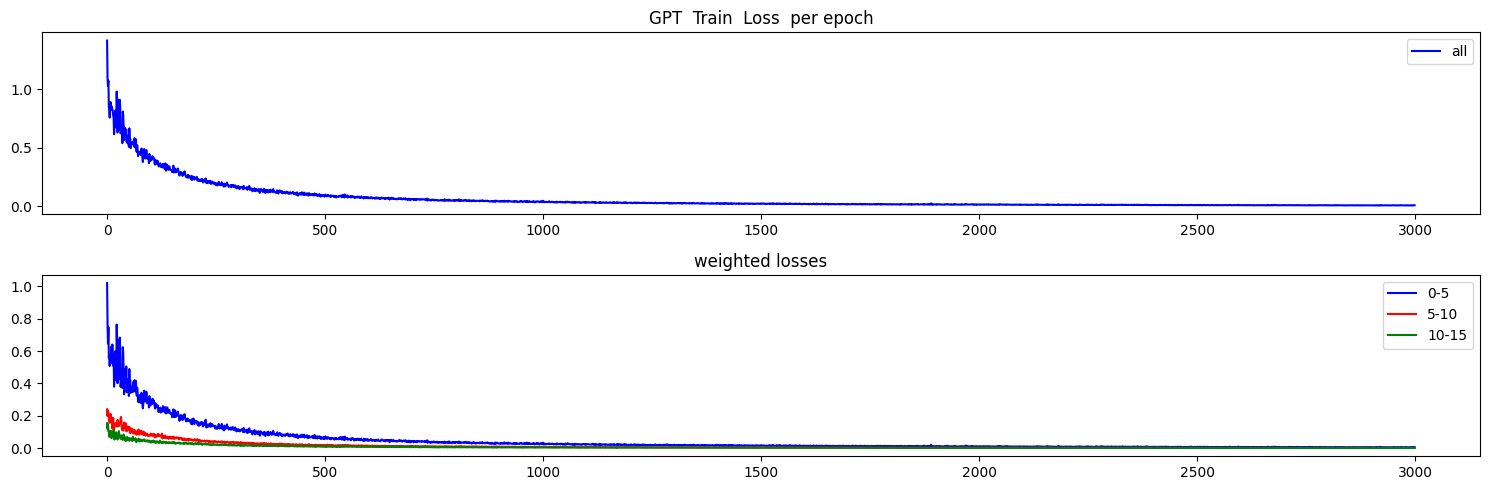

max tokens  14
torch.Size([1, 5, 27])
Test MSE Loss - SI only:  0.1790774166584015
Test MSE Loss - SI only 0-5:  0.058743059635162354
Test MSE Loss - SI only 5-10:  0.4707164764404297
Test MSE Loss - SI only 10-15:  0.07784735411405563
mae, mse, rmse, mape, mspe, rse, corr
(0.29029575, 0.17907742, 0.4231754, 1.1773195, 1.7630137, 1.018434)
Testing R**2 - SI only:  -0.03720795180754277
Testing R**2 - SI only:  -0.03720795180754277
Testing R**2 - All features:  0.42015604972953213
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0


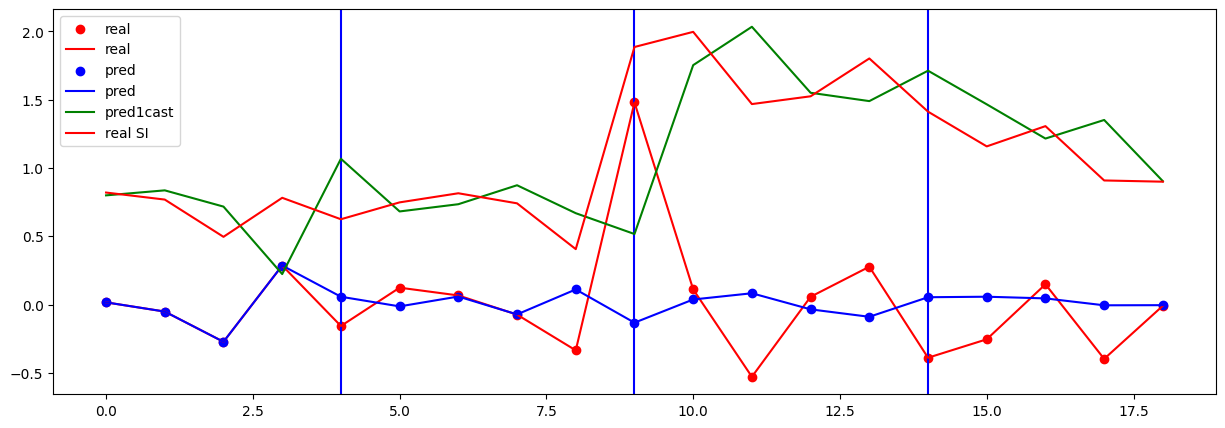

In [74]:

the_offset = 0   ## 0, 15, 30, 45, 60, 75, 90, 105

index_to_slice = 436

index_to_slice = index_to_slice + the_offset

print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]
## sliced_chunk_CIVS

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

print( train_CIVS.shape )
print( test_CIVS.shape )

## test_CIVS 

chunk_slideWind_train = train_CIVS[ :  ] 

print( chunk_slideWind_train.shape )

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk_slideWind_train  ) ## remove data_zh - RC

## func_zh_infer_on_train_set(si_GPT, history_GPT, x_means, x_standard_devs, data_zh )    ## remove RC 

results_string = function_test_rc(  chunk_slideWind_train, test_CIVS, si_GPT, x_means, x_standard_devs )

results_string = results_string + "," + str( the_offset ) + "," + "SlidWind1" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()

np.savetxt("for_excel_7_window.csv", excel_matrix, delimiter=",")




## 015 to 030


451
571
15
(105, 27)
(15, 27)
(105, 27)
torch.Size([105, 27])
0 train loss =  1.016013741493225
seq length of pred =  15
500 train loss =  0.06887772679328918
seq length of pred =  15
1000 train loss =  0.034225914627313614
seq length of pred =  15
1500 train loss =  0.017971334978938103
seq length of pred =  15
2000 train loss =  0.011852484196424484
seq length of pred =  15
2500 train loss =  0.007951316423714161
seq length of pred =  15


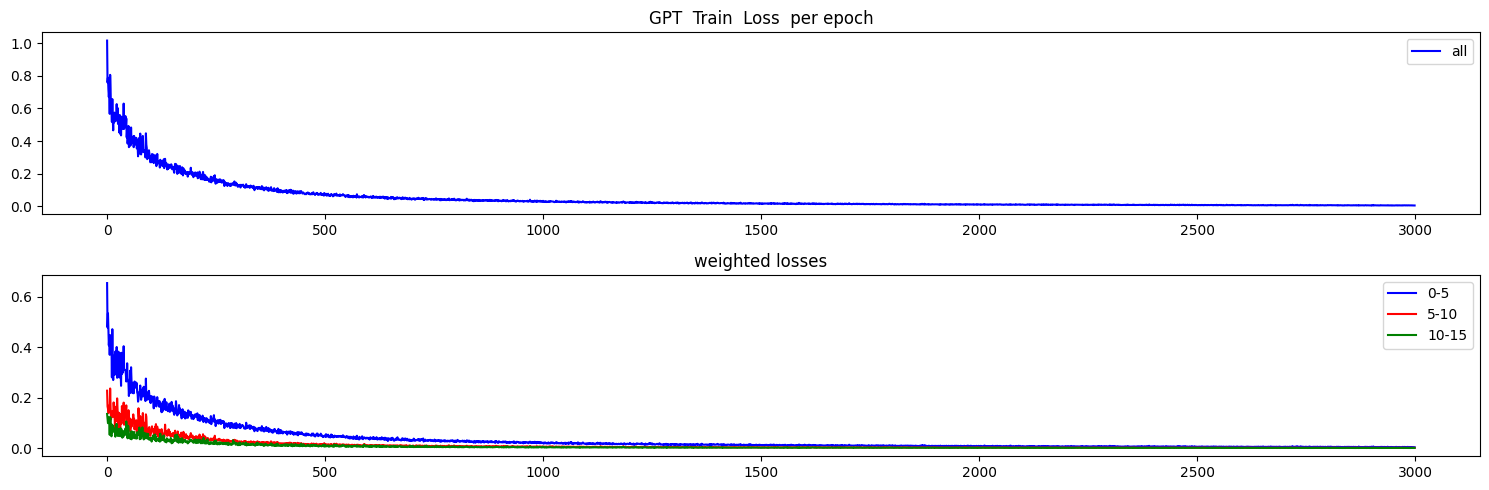

max tokens  14
torch.Size([1, 5, 27])
Test MSE Loss - SI only:  0.05442991852760315
Test MSE Loss - SI only 0-5:  0.032307177782058716
Test MSE Loss - SI only 5-10:  0.017588946968317032
Test MSE Loss - SI only 10-15:  0.030936473980545998
mae, mse, rmse, mape, mspe, rse, corr
(0.18157749, 0.05442992, 0.2333022, 5.063951, 134.14897, 1.4865763)
Testing R**2 - SI only:  -1.2099095405754192
Testing R**2 - SI only:  -1.2099095405754192
Testing R**2 - All features:  0.8993291912796111
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0


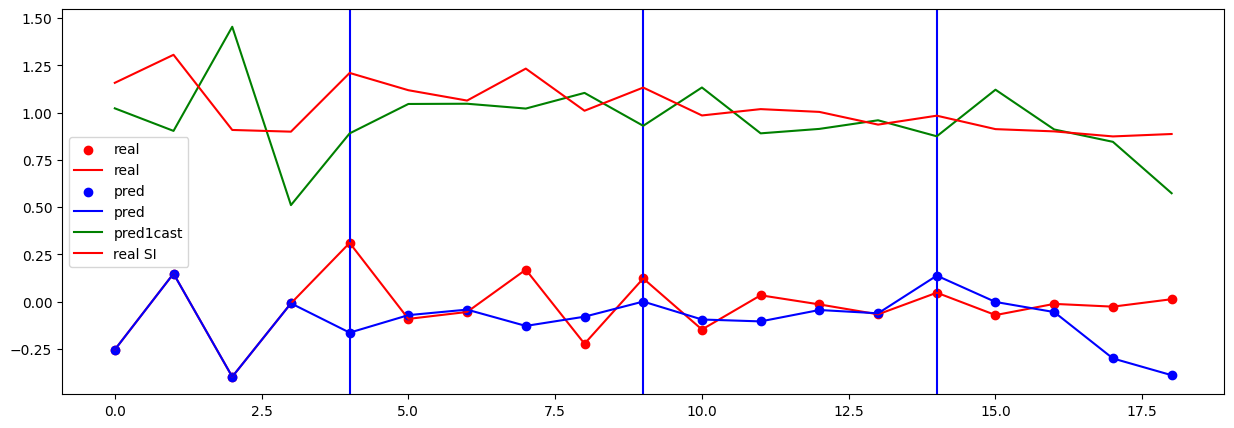

In [75]:

the_offset = 15   ## 0, 15, 30, 45, 60, 75, 90, 105

index_to_slice = 436

index_to_slice = index_to_slice + the_offset

print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]
## sliced_chunk_CIVS

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

print( train_CIVS.shape )
print( test_CIVS.shape )

## test_CIVS 

chunk_slideWind_train = train_CIVS[ :  ] 

print( chunk_slideWind_train.shape )

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk_slideWind_train  )

results_string = function_test_rc(  chunk_slideWind_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + str( the_offset ) + "," + "SlidWind1" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()

np.savetxt("for_excel_7_window.csv", excel_matrix, delimiter=",")



## 030 to 045


466
586
15
(105, 27)
(15, 27)
(105, 27)
torch.Size([105, 27])
0 train loss =  1.0269099473953247
seq length of pred =  15
500 train loss =  0.08427409827709198
seq length of pred =  15
1000 train loss =  0.03779126703739166
seq length of pred =  15
1500 train loss =  0.020229987800121307
seq length of pred =  15
2000 train loss =  0.015244487673044205
seq length of pred =  15
2500 train loss =  0.011958622373640537
seq length of pred =  15


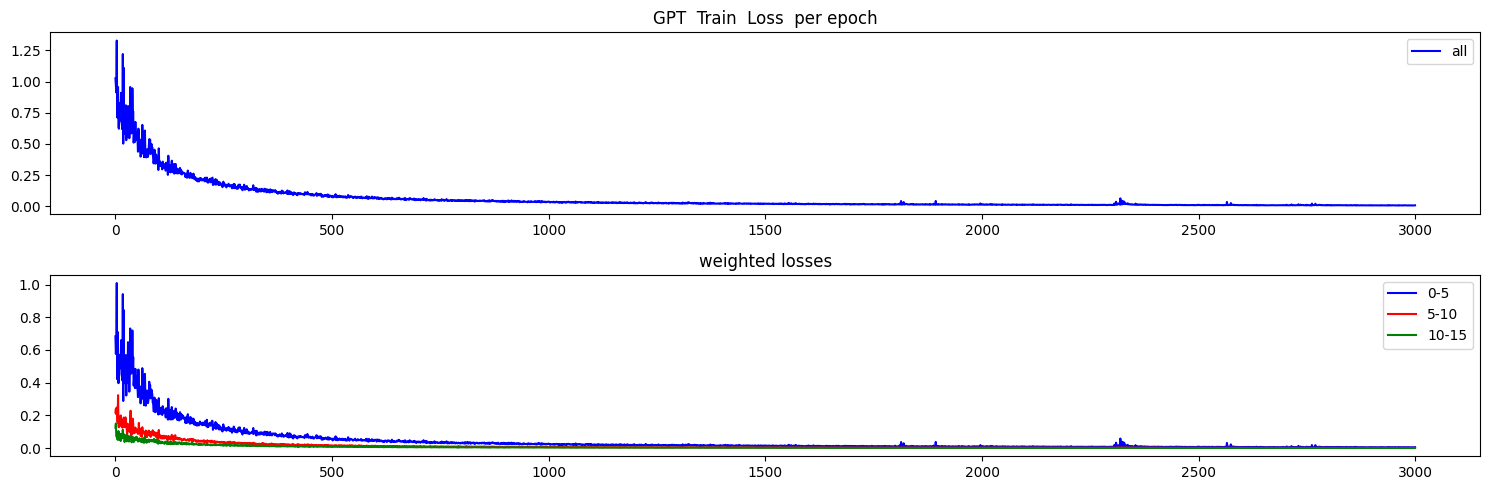

max tokens  14
torch.Size([1, 5, 27])
Test MSE Loss - SI only:  0.07553539425134659
Test MSE Loss - SI only 0-5:  0.1003146544098854
Test MSE Loss - SI only 5-10:  0.15934596955776215
Test MSE Loss - SI only 10-15:  0.023514889180660248
mae, mse, rmse, mape, mspe, rse, corr
(0.20202103, 0.07553539, 0.27483702, 1.8246211, 5.1277285, 1.1243578)
Testing R**2 - SI only:  -0.26418085849965056
Testing R**2 - SI only:  -0.26418085849965056
Testing R**2 - All features:  0.7494123214079966
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0


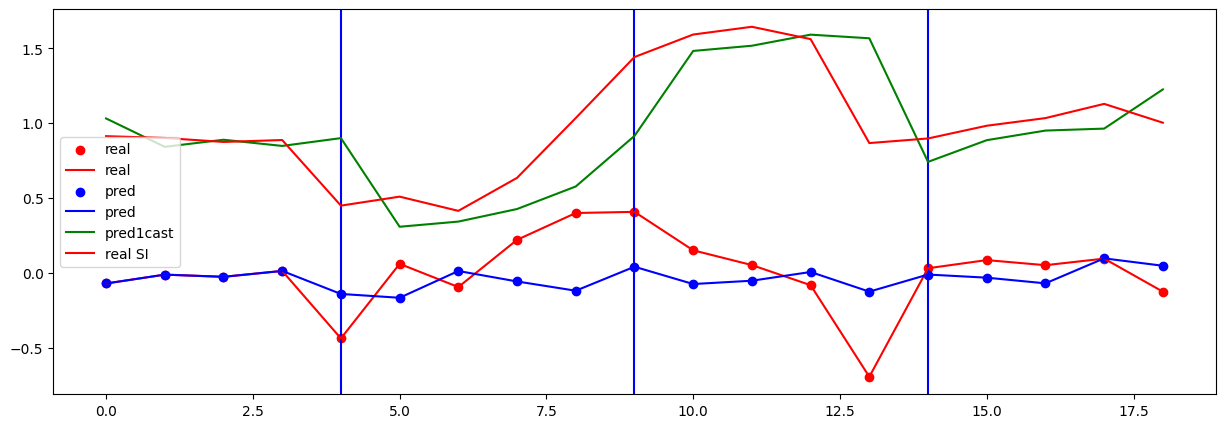

In [76]:

the_offset = 30  ## 0, 15, 30, 45, 60, 75, 90, 105

index_to_slice = 436

index_to_slice = index_to_slice + the_offset

print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]
## sliced_chunk_CIVS

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

print( train_CIVS.shape )
print( test_CIVS.shape )

## test_CIVS 

chunk_slideWind_train = train_CIVS[ :  ] 

print( chunk_slideWind_train.shape )

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk_slideWind_train  )

results_string = function_test_rc(  chunk_slideWind_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + str( the_offset ) + "," + "SlidWind1" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()

np.savetxt("for_excel_7_window.csv", excel_matrix, delimiter=",")



## 045 to 060


481
601
15
(105, 27)
(15, 27)
(105, 27)
torch.Size([105, 27])
0 train loss =  1.0925273895263672
seq length of pred =  15
500 train loss =  0.07998017966747284
seq length of pred =  15
1000 train loss =  0.034692976623773575
seq length of pred =  15
1500 train loss =  0.020008930936455727
seq length of pred =  15
2000 train loss =  0.01277933083474636
seq length of pred =  15
2500 train loss =  0.023929007351398468
seq length of pred =  15


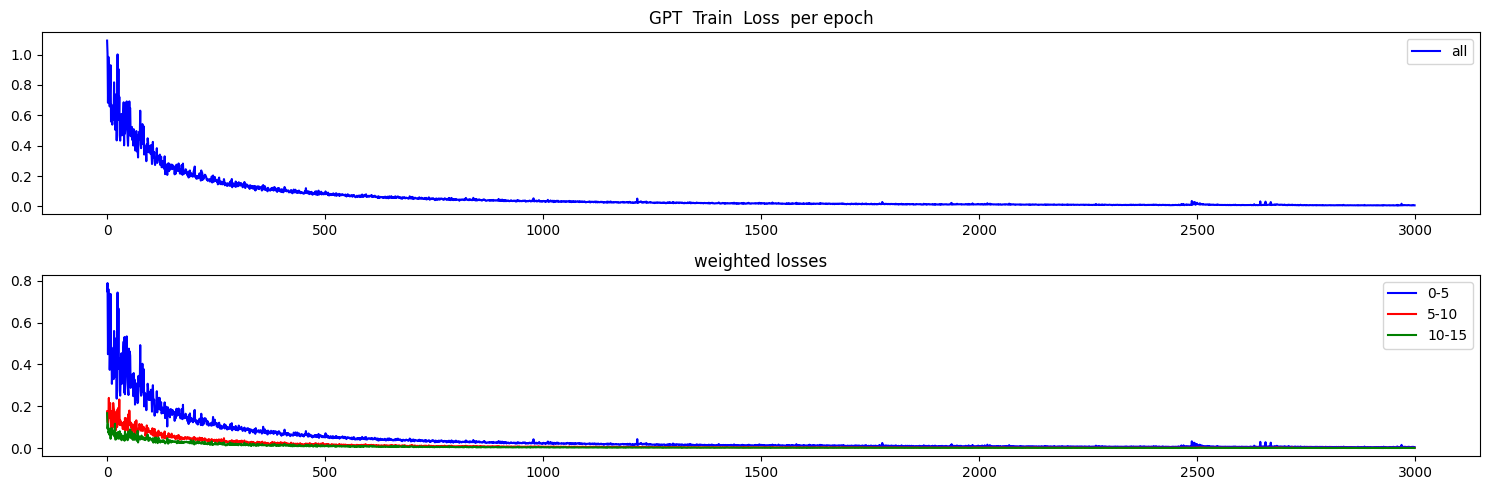

max tokens  14
torch.Size([1, 5, 27])
Test MSE Loss - SI only:  0.021699829027056694
Test MSE Loss - SI only 0-5:  0.021095668897032738
Test MSE Loss - SI only 5-10:  0.04630215838551521
Test MSE Loss - SI only 10-15:  0.004082824103534222
mae, mse, rmse, mape, mspe, rse, corr
(0.11078671, 0.02169983, 0.14730862, 1.9030529, 8.507672, 1.0949421)
Testing R**2 - SI only:  -0.19889813417261637
Testing R**2 - SI only:  -0.19889813417261637
Testing R**2 - All features:  0.9500916532698206
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0


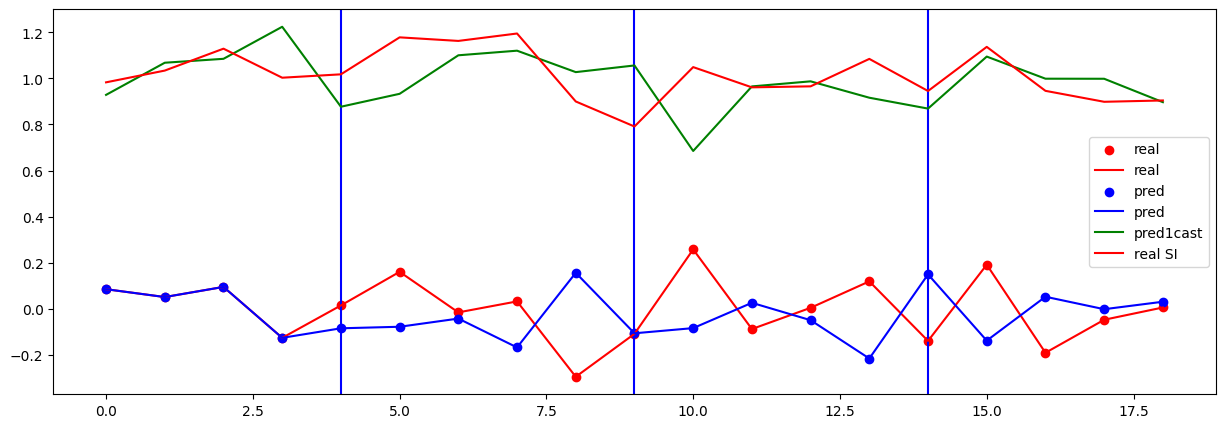

In [77]:

the_offset = 45   ## 0, 15, 30, 45, 60, 75, 90, 105

index_to_slice = 436

index_to_slice = index_to_slice + the_offset

print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]
## sliced_chunk_CIVS

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

print( train_CIVS.shape )
print( test_CIVS.shape )

## test_CIVS 

chunk_slideWind_train = train_CIVS[ :  ] 

print( chunk_slideWind_train.shape )

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk_slideWind_train  )

results_string = function_test_rc(  chunk_slideWind_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + str( the_offset ) + "," + "SlidWind1" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()

np.savetxt("for_excel_7_window.csv", excel_matrix, delimiter=",")



## 060 to 075


496
616
15
(105, 27)
(15, 27)
(105, 27)
torch.Size([105, 27])
0 train loss =  1.3487833738327026
seq length of pred =  15
500 train loss =  0.0827547162771225
seq length of pred =  15
1000 train loss =  0.03609814494848251
seq length of pred =  15
1500 train loss =  0.020697711035609245
seq length of pred =  15
2000 train loss =  0.014676234684884548
seq length of pred =  15
2500 train loss =  0.01123310811817646
seq length of pred =  15


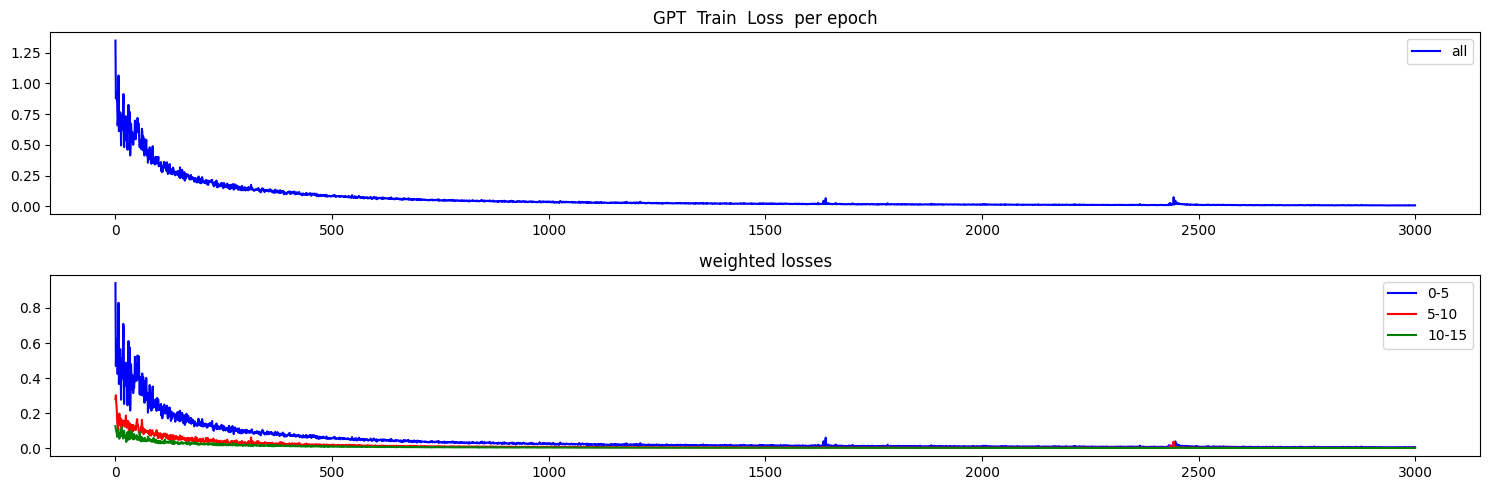

max tokens  14
torch.Size([1, 5, 27])
Test MSE Loss - SI only:  0.06304433196783066
Test MSE Loss - SI only 0-5:  0.09044946730136871
Test MSE Loss - SI only 5-10:  0.033675484359264374
Test MSE Loss - SI only 10-15:  0.05965711921453476
mae, mse, rmse, mape, mspe, rse, corr
(0.20935605, 0.06304434, 0.25108632, 53.45861, 50031.03, 1.6215887)
Testing R**2 - SI only:  -1.6295497259531282
Testing R**2 - SI only:  -1.6295497259531282
Testing R**2 - All features:  0.9961779818491333
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0


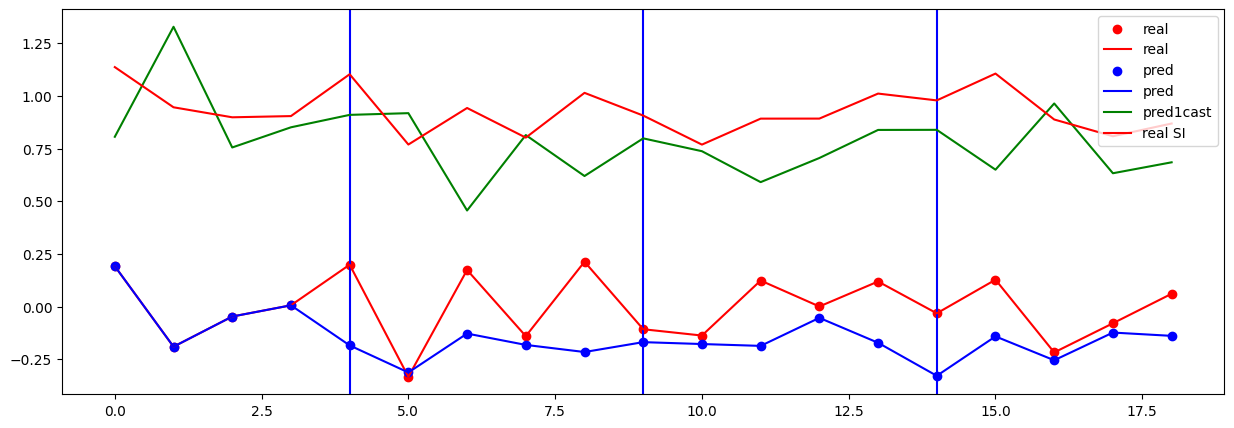

In [78]:

the_offset = 60   ## 0, 15, 30, 45, 60, 75, 90, 105

index_to_slice = 436

index_to_slice = index_to_slice + the_offset

print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]
## sliced_chunk_CIVS

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

print( train_CIVS.shape )
print( test_CIVS.shape )

## test_CIVS 

chunk_slideWind_train = train_CIVS[ :  ] 

print( chunk_slideWind_train.shape )

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk_slideWind_train  )

results_string = function_test_rc(  chunk_slideWind_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + str( the_offset ) + "," + "SlidWind1" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()

np.savetxt("for_excel_7_window.csv", excel_matrix, delimiter=",")



## 075 to 090


511
631
15
(105, 27)
(15, 27)
(105, 27)
torch.Size([105, 27])
0 train loss =  1.1536096334457397
seq length of pred =  15
500 train loss =  0.08353498578071594
seq length of pred =  15
1000 train loss =  0.0364844873547554
seq length of pred =  15
1500 train loss =  0.023895936086773872
seq length of pred =  15
2000 train loss =  0.013141131959855556
seq length of pred =  15
2500 train loss =  0.00874029565602541
seq length of pred =  15


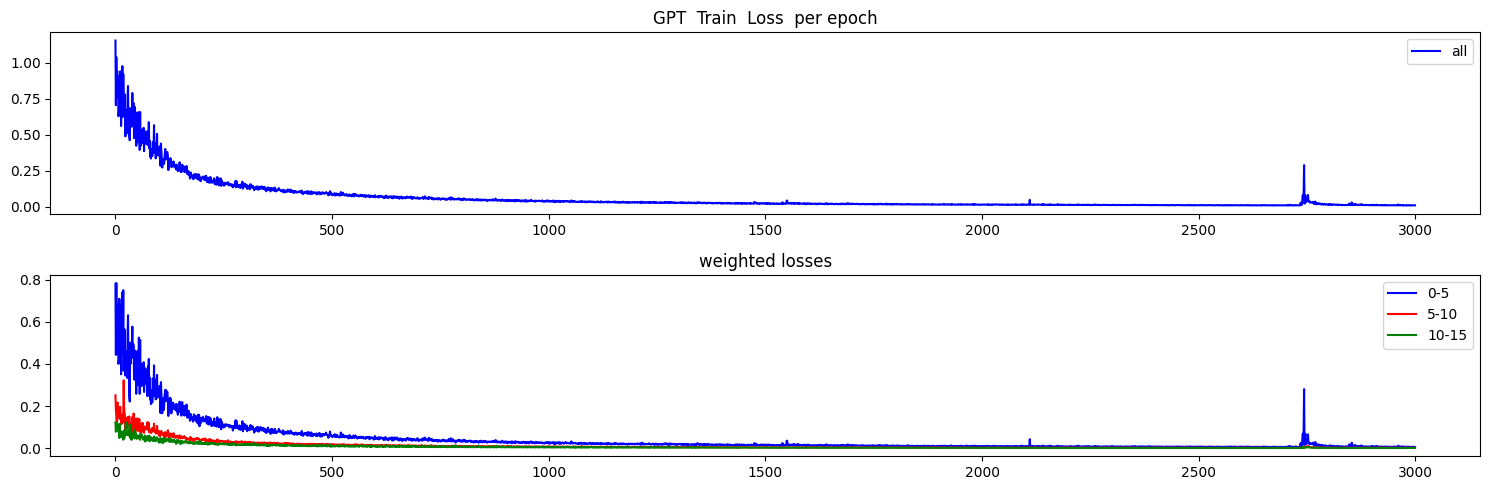

max tokens  14
torch.Size([1, 5, 27])
Test MSE Loss - SI only:  0.03589487820863724
Test MSE Loss - SI only 0-5:  0.02846440300345421
Test MSE Loss - SI only 5-10:  0.04954751208424568
Test MSE Loss - SI only 10-15:  0.02169131115078926
mae, mse, rmse, mape, mspe, rse, corr
(0.16319263, 0.03589488, 0.18945944, 3.3934479, 36.202904, 1.3326966)
Testing R**2 - SI only:  -0.776080342490697
Testing R**2 - SI only:  -0.776080342490697
Testing R**2 - All features:  0.9726291427970235
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0


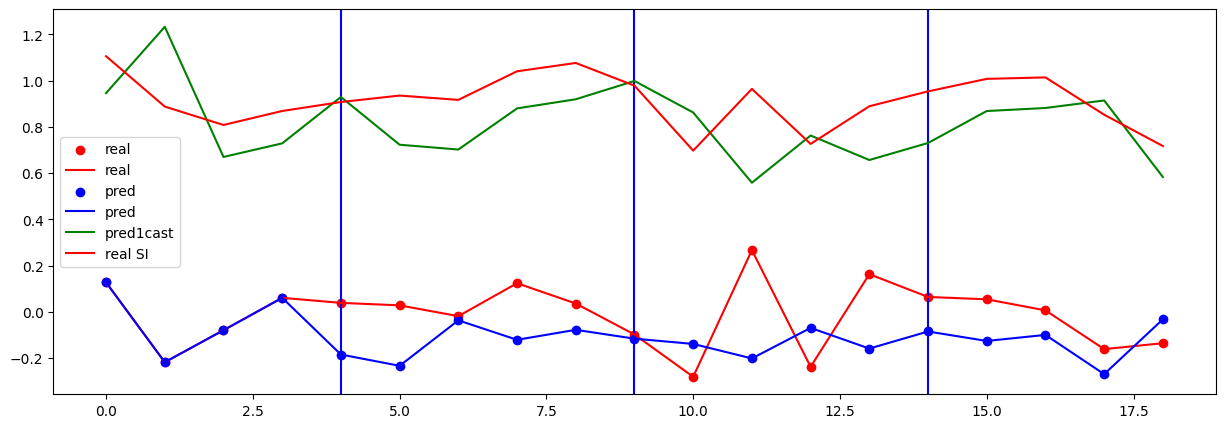

In [79]:

the_offset = 75   ## 0, 15, 30, 45, 60, 75, 90, 105

index_to_slice = 436

index_to_slice = index_to_slice + the_offset

print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]
## sliced_chunk_CIVS

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

print( train_CIVS.shape )
print( test_CIVS.shape )

## test_CIVS 

chunk_slideWind_train = train_CIVS[ :  ] 

print( chunk_slideWind_train.shape )

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk_slideWind_train  )

results_string = function_test_rc(  chunk_slideWind_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + str( the_offset ) + "," + "SlidWind1" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()

np.savetxt("for_excel_7_window.csv", excel_matrix, delimiter=",")



## 090 to 105


526
646
15
(105, 27)
(15, 27)
(105, 27)
torch.Size([105, 27])
0 train loss =  1.4162877798080444
seq length of pred =  15
500 train loss =  0.09316980093717575
seq length of pred =  15
1000 train loss =  0.03473416343331337
seq length of pred =  15
1500 train loss =  0.021012060344219208
seq length of pred =  15
2000 train loss =  0.013502255082130432
seq length of pred =  15
2500 train loss =  0.008026421070098877
seq length of pred =  15


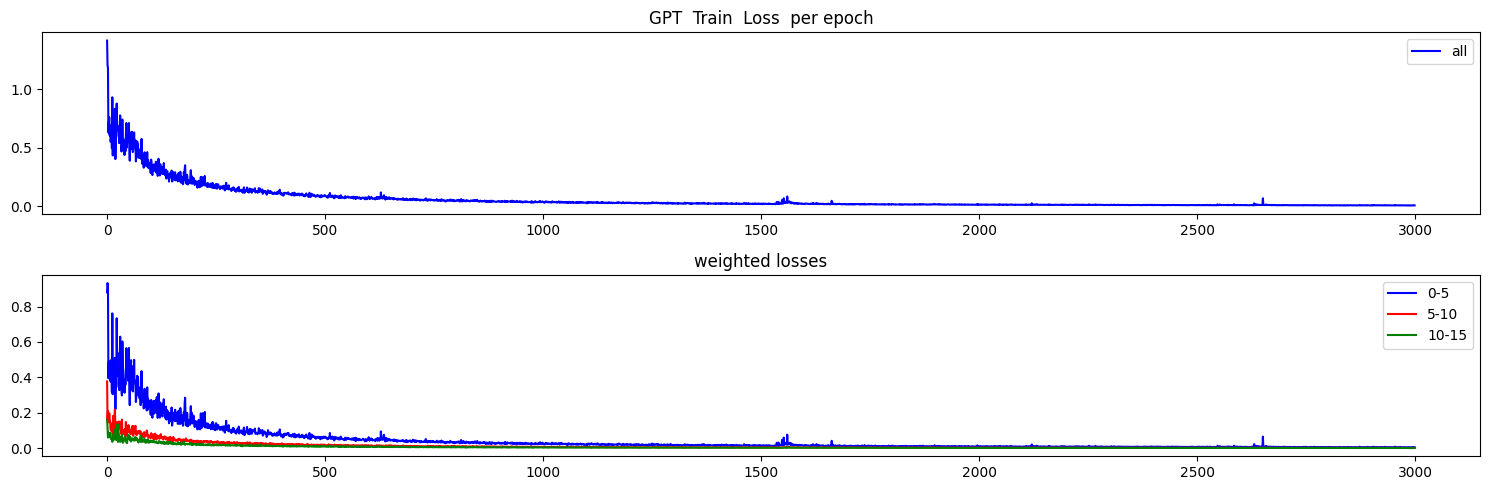

max tokens  14
torch.Size([1, 5, 27])
Test MSE Loss - SI only:  0.043497342616319656
Test MSE Loss - SI only 0-5:  0.03622075170278549
Test MSE Loss - SI only 5-10:  0.0715106874704361
Test MSE Loss - SI only 10-15:  0.05132843926548958
mae, mse, rmse, mape, mspe, rse, corr
(0.17461677, 0.04349735, 0.20856018, 3.8160255, 49.314075, 1.2479016)
Testing R**2 - SI only:  -0.5572584442109114
Testing R**2 - SI only:  -0.5572584442109114
Testing R**2 - All features:  0.9574988239676717
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0
this ... 0.0


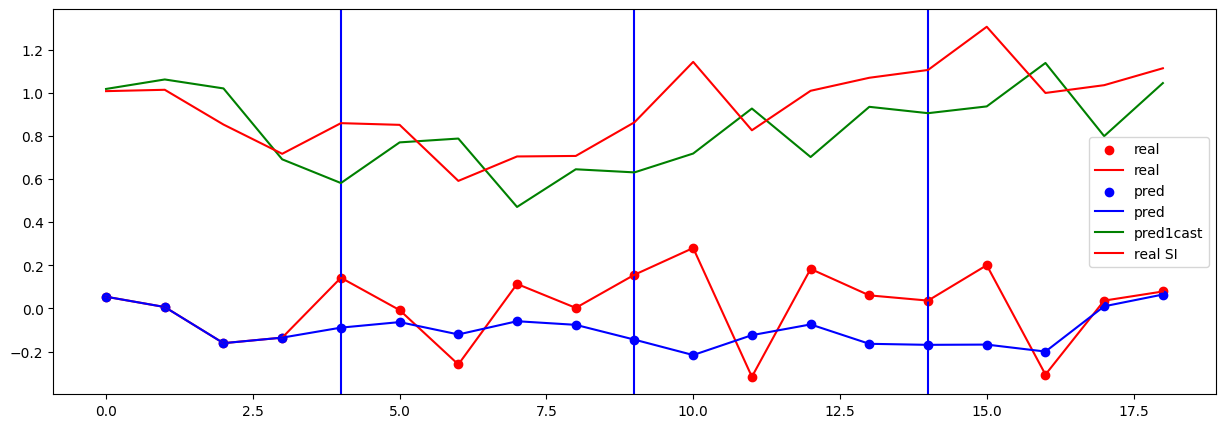

In [80]:

the_offset = 90   ## 0, 15, 30, 45, 60, 75, 90, 105

index_to_slice = 436

index_to_slice = index_to_slice + the_offset

print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]
## sliced_chunk_CIVS

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

print( train_CIVS.shape )
print( test_CIVS.shape )

## test_CIVS 

chunk_slideWind_train = train_CIVS[ :  ] 

print( chunk_slideWind_train.shape )

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk_slideWind_train  )

results_string = function_test_rc(  chunk_slideWind_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + str( the_offset ) + "," + "SlidWind1" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()

excel_matrix = np.round(excel_matrix, 2)
np.savetxt("for_excel_7_window.csv", excel_matrix, delimiter=",")



## Add the dates ( ??) 


In [81]:

index_to_slice    = 436

sliced_chunk_DATES_MAP = df_Dates_Map[ index_to_slice : index_to_slice + 250]['Date_Map']
sliced_chunk_DATES_MAP



436    2021-09-01 17:11:00
437    2021-09-01 18:40:00
438    2021-09-02 00:15:00
439    2021-09-02 02:57:00
440    2021-09-02 05:05:00
              ...         
681    2021-09-28 00:39:00
682    2021-09-29 00:55:00
683    2021-09-29 04:44:00
684    2021-09-29 07:19:00
685    2021-09-29 09:53:00
Name: Date_Map, Length: 250, dtype: object

In [82]:

sliced_chunk_DATES_MAP_np = sliced_chunk_DATES_MAP.to_numpy()

sliced_chunk_DATES_MAP_np = np.expand_dims(sliced_chunk_DATES_MAP_np, axis=1)


sliced_chunk_DATES_MAP_np.shape



(250, 1)

In [83]:

excel_matrix.shape


(250, 30)

In [84]:

## excel_matrix = np.concatenate((sliced_chunk_DATES_MAP_np, excel_matrix), axis=1)   ## add this back for dates

excel_matrix.shape


(250, 30)

In [85]:

excel_matrix_pd = pd.DataFrame(excel_matrix)


In [86]:

excel_matrix_pd


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.02,0.02,0.82,0.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.05,-0.05,0.77,0.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.27,-0.27,0.50,0.72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.29,0.29,0.78,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.16,0.06,0.62,1.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:

excel_matrix_pd.to_csv("for_excel_7_window.csv")
    
## np.savetxt("for_excel_7_window.csv", excel_matrix, delimiter=",")


In [88]:
## DrZhao


## Write to file


In [89]:

line = 'id, delta_real,delta_pred,DrZ_real,DrZ_pred,delta_real,delta_pred,DrZ_real,DrZ_pred,delta_real,delta_pred,DrZ_real,DrZ_pred,'
line = line + 'delta_real,delta_pred,DrZ_real,DrZ_pred,delta_real,delta_pred,DrZ_real,DrZ_pred,delta_real,delta_pred,DrZ_real,DrZ_pred,'
line = line + 'delta_real,delta_pred,DrZ_real,DrZ_pred,None,None'
with open("for_excel_7_window.csv", 'r+') as file: 
 file_data = file.read() 
 file.seek(0, 0) 
 file.write(line + '\n' + file_data)
file.close()



## Start of the 6 Random Runs



## Pick slice randomly


In [ ]:

training_chunk = 400


In [ ]:

length_n  = int( for_RNN_data_CIVS.shape[0] )

length_n



## Run 1


In [ ]:
from datetime import datetime

the_range = training_chunk + block_size

## random.seed()        ## RC
random.seed( datetime.now().timestamp() )

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice


In [ ]:

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )


In [ ]:

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]


In [ ]:

sliced_chunk_CIVS



## Train and test


In [ ]:

n = block_size

print( n )


In [ ]:

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]


In [ ]:

print( train_CIVS.shape )
print( test_CIVS.shape )


In [ ]:

test_CIVS 


In [ ]:

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


In [ ]:

print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


In [ ]:
'''
print(idx.shape)
        vals, indeces = torch.max( idx, dim=2  )
        print( vals.shape )
        print( indeces )
        print(idx.shape)
        input()
'''

In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run1" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 2


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ]  


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )





In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run2" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 3


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string  = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run3" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 4


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run4" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close() 



## Run 5


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run5" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



## Run 6


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

results_string = function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "300to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

results_string = function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "200to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

results_string = function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "100to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

results_string = function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )

results_string = results_string + "," + "run6" + "," + "000to400" + "," + str(max_iters) + "," + comment_exp +  "\n"

exp_results_file = open('experiment_results_file_GPT_CIVS.txt', 'a')
exp_results_file.write( results_string ) 
exp_results_file.close()
